https://stackoverflow.com/questions/26089893/understanding-numpys-einsum

In [1]:
import numpy as np
import torch
from IPython.display import Image

## basics

- 适用于 ndarray（numpy） 以及 tensor（pytorch） 对应的矩阵操作，更灵活，更 general
- 工作原理，通过操作 index(axis/dim) 来匹配矩阵操作
    - 三个准则
        - 在不同输入（输入：`->` 左侧，逗号分割）之间重复出现的索引表示沿着该维度进行乘法
            - `ik,kj->ij`（这里的 `k`，作为第一个矩阵的行，第二个矩阵的列）
        - 只出现在输入中（未出现在输出中）的索引表示在这一维度上的求和（reduce）
            - `ik,kj->ij`（这里的 `k`）
        - 输出中（`->`右侧）维度的顺序可以是任意的，可以很方面地进行 permute
            - `ik,kj->ji`（进一步对输出进行转置）
    - $C=A\cdot B$
        - $C_{ij}=\sum_kA_{ik}B_{kj}$
            - $A$ 的第 `i` 行，$B$ 的第 `j` 列；
        - einsum way：$C_{ij}=A_{ik}B_{kj}$

- 常见经典操作：
    - permutation
        - 'ij->ji'
    - summation
        - 'ij->': all sum
        - row/column sum
            - 'ij->i': row sum
            - 'ij->j': column sum
            
    - (batch) matrix multi
        - matrix - vector multi: ''
        - matrix - matrix
        
    - element-wise mult (Hadamard product)

    - inner/outer product
        - 'i,i->': inner product
        - 'i,j->ij': outer product
    


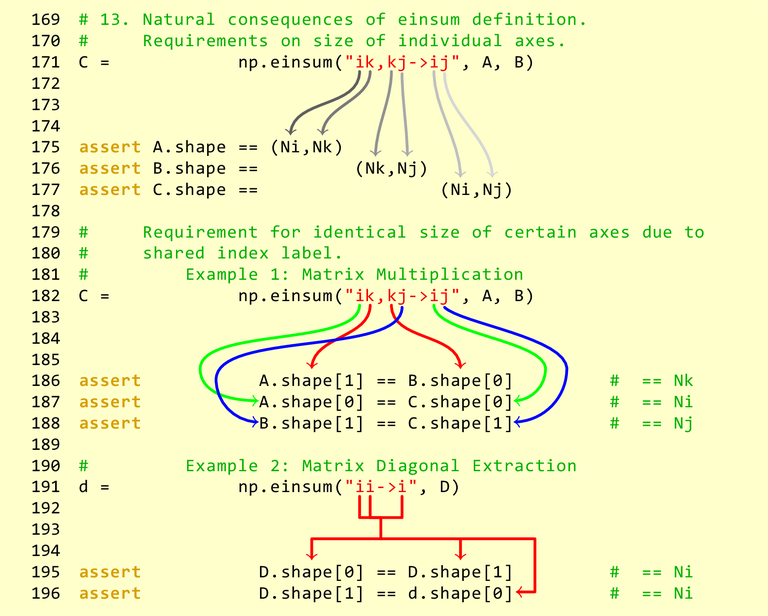

In [3]:
Image('./imgs/numpy_einsum.png', width=500)

## numpy demo

### basics

In [26]:
# 'i->'
x = np.asarray([1, 2, 3])
sum_x = np.einsum('i->', x)
assert sum_x == 6
# 'ijk->kji'
x = np.random.rand(2, 3, 4)
np.alltrue(np.einsum('ijk->jki', x) == x.transpose(1, 2, 0))

True

### `ik,kj->ij`：矩阵乘法

In [19]:
np.random.seed(43)

A = np.random.rand(3, 5)
B = np.random.rand(5, 2)

C1 = np.zeros((3, 2))

# print(A.dot(B))

for i in range(3):
    for j in range(2):
        total = 0
        for k in range(5):
             total += A[i, k] * B[k, j]
        C1[i, j] = total
C1

array([[0.8764075 , 0.44507204],
       [1.58530436, 1.19667538],
       [1.43782141, 0.84566376]])

In [44]:
# ik: A
# kj: B
# i,j: free indices，外层循环
# k: summation index，内层循环，被 reduce 掉的
C2 = np.einsum('ik,kj->ij', A, B)

In [21]:
np.alltrue(C1 == C2)

True

### `i,j->ij`：向量外积（outer product）

$$
out[i, j] = a[i] * b[j]
$$

In [17]:
a = np.random.rand(5)
b = np.random.rand(3)
c1 = np.outer(a, b)
# i, j: free indices, used in output
# summation index: None
c2 = np.einsum('i,j->ij', a, b)
np.alltrue(c1 == c2)
c2

array([[0.72231527, 0.39663104, 0.6658378 ],
       [0.53486475, 0.29369996, 0.49304395],
       [0.3235543 , 0.17766713, 0.29825575],
       [0.40759539, 0.22381499, 0.37572571],
       [0.2989778 , 0.16417191, 0.27560088]])

In [23]:
c = np.zeros((5, 3))
for i in range(5):
    for j in range(3):
        total = 0
        # no sum loop
        total += a[i]*b[j]
        c[i, j] = total
c

array([[0.72231527, 0.39663104, 0.6658378 ],
       [0.53486475, 0.29369996, 0.49304395],
       [0.3235543 , 0.17766713, 0.29825575],
       [0.40759539, 0.22381499, 0.37572571],
       [0.2989778 , 0.16417191, 0.27560088]])

## torch demo

### permutation

In [36]:
x = torch.rand((2, 3))
print(x)
x_t = torch.einsum('ij->ji', x)
print(x_t)
torch.equal(x.transpose(1, 0), x_t)

tensor([[0.2547, 0.2151, 0.2986],
        [0.4207, 0.0754, 0.6783]])
tensor([[0.2547, 0.4207],
        [0.2151, 0.0754],
        [0.2986, 0.6783]])


True

In [37]:
x

tensor([[0.2547, 0.2151, 0.2986],
        [0.4207, 0.0754, 0.6783]])

### summation

In [43]:
torch.equal(torch.einsum('ij->', x), x.sum())

True

In [41]:
torch.equal(torch.einsum('ij->i', x), x.sum(axis=1))

True

In [42]:
torch.equal(torch.einsum('ij->j', x), x.sum(axis=0))

True

### multiplication

In [48]:
# matrix - vector
v = torch.rand(3)
torch.einsum('ij,j->i', x, v)

tensor([0.4256, 0.7571])

In [50]:
x @ v.reshape(-1, 1)

tensor([[0.4256],
        [0.7571]])

In [59]:
# matrix - vector
v = torch.rand((1, 3))
torch.einsum('ij,kj->ik', x, v)

tensor([[0.2843],
        [0.4031]])

In [61]:
print(x @ v.transpose(1, 0))
print(x.mm(v.t()))

tensor([[0.2843],
        [0.4031]])
tensor([[0.2843],
        [0.4031]])


In [63]:
# matrix - vector
v = torch.rand((3, 1))
torch.einsum('ij,jk->ik', x, v)

tensor([[0.5181],
        [0.7715]])

In [64]:
x @ v

tensor([[0.5181],
        [0.7715]])

In [65]:
# matrix
torch.einsum('ij,kj->ik', x, x)

tensor([[0.2003, 0.3259],
        [0.3259, 0.6428]])

In [66]:
x.mm(x.t())

tensor([[0.2003, 0.3259],
        [0.3259, 0.6428]])

### inner/outer product

In [67]:
torch.einsum('i,i->', x[0], x[0])

tensor(0.2003)

In [68]:
torch.sum(x[0]*x[0])

tensor(0.2003)

In [70]:
torch.einsum('i,j->ij', x[0], x[0])

tensor([[0.0649, 0.0548, 0.0761],
        [0.0548, 0.0463, 0.0642],
        [0.0761, 0.0642, 0.0892]])

In [71]:
torch.outer(x[0], x[0])

tensor([[0.0649, 0.0548, 0.0761],
        [0.0548, 0.0463, 0.0642],
        [0.0761, 0.0642, 0.0892]])

### dot product with matrix 

In [72]:
torch.einsum('ij,ij->', x, x)

tensor(0.8431)

In [73]:
torch.sum(x * x)

tensor(0.8431)

### Hadamard product

In [82]:
torch.einsum('ij,ij->ij', x, x)

tensor([[8.3350e-01, 4.9147e-01, 1.3135e-01, 5.5694e-05, 5.1112e-01],
        [2.4599e-01, 3.7869e-01, 3.2668e-03, 7.1125e-01, 1.5709e-01],
        [3.9248e-01, 1.3680e-01, 8.6527e-01, 8.2573e-01, 9.8124e-04],
        [6.5214e-02, 7.0714e-04, 7.6283e-01, 4.7111e-01, 2.5561e-02],
        [9.6552e-01, 7.8141e-01, 5.8040e-01, 2.6186e-01, 5.5733e-01]])

In [83]:
x * x

tensor([[8.3350e-01, 4.9147e-01, 1.3135e-01, 5.5694e-05, 5.1112e-01],
        [2.4599e-01, 3.7869e-01, 3.2668e-03, 7.1125e-01, 1.5709e-01],
        [3.9248e-01, 1.3680e-01, 8.6527e-01, 8.2573e-01, 9.8124e-04],
        [6.5214e-02, 7.0714e-04, 7.6283e-01, 4.7111e-01, 2.5561e-02],
        [9.6552e-01, 7.8141e-01, 5.8040e-01, 2.6186e-01, 5.5733e-01]])

### batch mm

In [84]:
x1 = torch.rand(4, 2, 5)
x2 = torch.rand(4, 5, 3)
x1.bmm(x2)

tensor([[[0.7476, 1.2334, 0.7442],
         [0.7805, 1.3598, 0.9277]],

        [[0.9196, 0.4849, 1.2628],
         [1.1046, 0.6893, 1.6264]],

        [[0.9355, 2.0841, 1.8561],
         [0.5296, 1.4321, 1.2054]],

        [[1.0077, 1.3104, 0.8044],
         [0.7875, 0.7498, 0.6341]]])

In [85]:
torch.einsum('ijk,ikm->ijm', x1, x2)

tensor([[[0.7476, 1.2334, 0.7442],
         [0.7805, 1.3598, 0.9277]],

        [[0.9196, 0.4849, 1.2628],
         [1.1046, 0.6893, 1.6264]],

        [[0.9355, 2.0841, 1.8561],
         [0.5296, 1.4321, 1.2054]],

        [[1.0077, 1.3104, 0.8044],
         [0.7875, 0.7498, 0.6341]]])

## misc

### `ii->i`：diagonal

- 00->0
- 11->1
- 22->2

In [77]:
x = torch.rand((5, 5))
print(x)
torch.einsum('ii->i', x)

tensor([[0.9130, 0.7010, 0.3624, 0.0075, 0.7149],
        [0.4960, 0.6154, 0.0572, 0.8434, 0.3964],
        [0.6265, 0.3699, 0.9302, 0.9087, 0.0313],
        [0.2554, 0.0266, 0.8734, 0.6864, 0.1599],
        [0.9826, 0.8840, 0.7618, 0.5117, 0.7465]])


tensor([0.9130, 0.6154, 0.9302, 0.6864, 0.7465])

### `ii->`: trace

In [92]:
x = torch.randint(0, 4, (3, 3))
print(x)
torch.einsum('ii->', x)

tensor([[1, 3, 1],
        [3, 2, 3],
        [0, 0, 2]])


tensor(5)

### `ijij->ij`

- 先 squeeze 再取对角

In [79]:
X = torch.arange(36).reshape(1, 6, 1, 6)   
X

tensor([[[[ 0,  1,  2,  3,  4,  5]],

         [[ 6,  7,  8,  9, 10, 11]],

         [[12, 13, 14, 15, 16, 17]],

         [[18, 19, 20, 21, 22, 23]],

         [[24, 25, 26, 27, 28, 29]],

         [[30, 31, 32, 33, 34, 35]]]])

In [81]:
torch.einsum('ijij->ij', X)

tensor([[ 0,  7, 14, 21, 28, 35]])